### Semi Supervised Learning - Overhead MNIST
Use K-Means clustering on the Overhead MNIST Dataset to identify a small subset of labelled images to seed the classification process.  
Link: https://www.kaggle.com/datasets/datamunge/overheadmnist  
Experiment with different (relatively small) values of K for this dataset.

### Importing the necessary libraries

In [1]:
from pathlib import Path
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from sklearn.utils import Bunch
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')
%load_ext memory_profiler
random.seed(1)

### Preparing the dataset

In [2]:
def create_dataset(path):
    '''
    function to import the datasets by converting the images to numpy arrays
    and labelling them according to the folder names
    '''
    directory = Path(path)
    object_dir = [_ for _ in directory.iterdir()]
    objects = [_.name for _ in object_dir]

    images = []
    classes = []
    for y, dire in enumerate(object_dir):
        for img in dire.iterdir():
            
            img = Image.open(img)

            # Normalizing, rotating and reflecting the images
            images.extend([np.array(img).flatten()/255, np.array(img.rotate(90)).flatten()/255, np.array(img.transpose(Image.FLIP_LEFT_RIGHT)).flatten()/255, np.array(img.transpose(Image.FLIP_TOP_BOTTOM)).flatten()/255])
            classes.extend([y, y, y, y])

    images = np.array(images)
    classes = np.array(classes)
    
    return Bunch(data = np.array(images), target = np.array(classes), target_names = objects)

In [3]:
# function to shuffle the datasets
def pair_shuffle(list1, list2):
    l = list(zip(list1, list2))
    random.shuffle(l)
    return zip(*l)

### Importing train and test datasets

In [4]:
data = create_dataset("./version2/train")

In [5]:
train_X, train_y = pair_shuffle(data.data, data.target)
train_X, train_y = np.array(train_X), np.array(train_y)

In [6]:
labels = data.target_names
print(labels)

['car', 'storage_tank', 'harbor', 'oil_gas_field', 'helicopter', 'stadium', 'parking_lot', 'plane', 'runway_mark', 'ship']


In [7]:
data = create_dataset("./version2/test")

In [8]:
test_X, test_y = pair_shuffle(data.data, data.target)
test_X, test_y = np.array(test_X), np.array(test_y)

- Counting the number of null values

In [9]:
np.isnan(train_X).sum(), np.isnan(test_X).sum()

(0, 0)

### Plotting the counts of the classes in the datasets

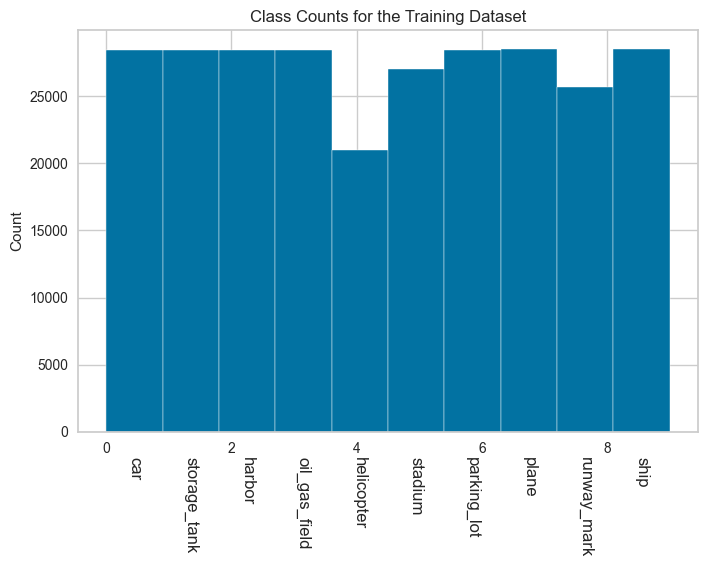

In [10]:
fig, ax = plt.subplots()
values, bins, bars = plt.hist(train_y, edgecolor = 'white')
bin_centers = 0.5 * np.diff(bins) + bins[:-1]

for i, (value, x) in enumerate(zip(values, bin_centers)):
    ax.annotate(labels[i], xy=(x, 0), xycoords=('data', 'axes fraction'), xytext=(0, -18), textcoords='offset points', va='top', ha='center', rotation = 270)
plt.subplots_adjust(bottom=0.15)

plt.ylabel("Count")
plt.title("Class Counts for the Training Dataset")
plt.show()

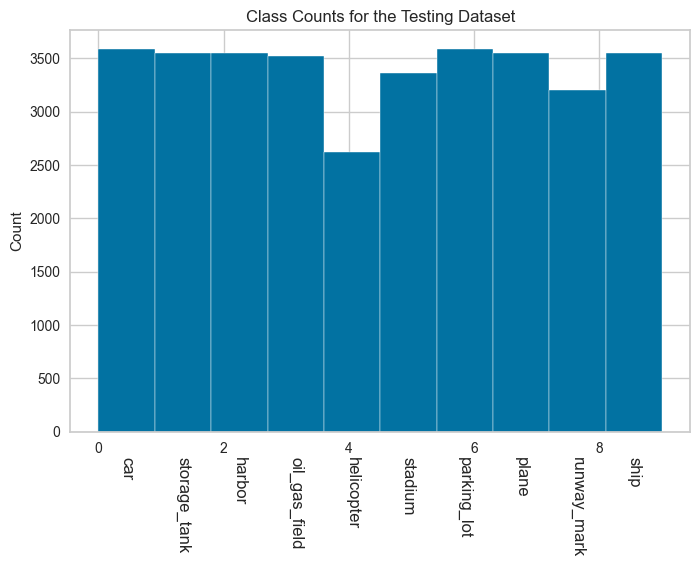

In [11]:
fig, ax = plt.subplots()
values, bins, bars = plt.hist(test_y, edgecolor = 'white')
bin_centers = 0.5 * np.diff(bins) + bins[:-1]

for i, (value, x) in enumerate(zip(values, bin_centers)):
    ax.annotate(labels[i], xy=(x, 0), xycoords=('data', 'axes fraction'), xytext=(0, -18), textcoords='offset points', va='top', ha='center', rotation = 270)
plt.subplots_adjust(bottom=0.15)

plt.ylabel("Count")
plt.title("Class Counts for the Testing Dataset")
plt.show()

### Plotting the images

In [12]:
def plotting(n, m, data, labels, names):
    plt.figure(figsize=(10, 10))
    for _ in range(n):
        for __ in range(m):
            index = _*m + __
            plt.subplot(n, m, index + 1)
            plt.axis("off")
            plt.imshow(data[index].reshape(28, 28)*255, interpolation="bilinear", cmap="binary")
            plt.title(names[labels[index]], fontsize = 10)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

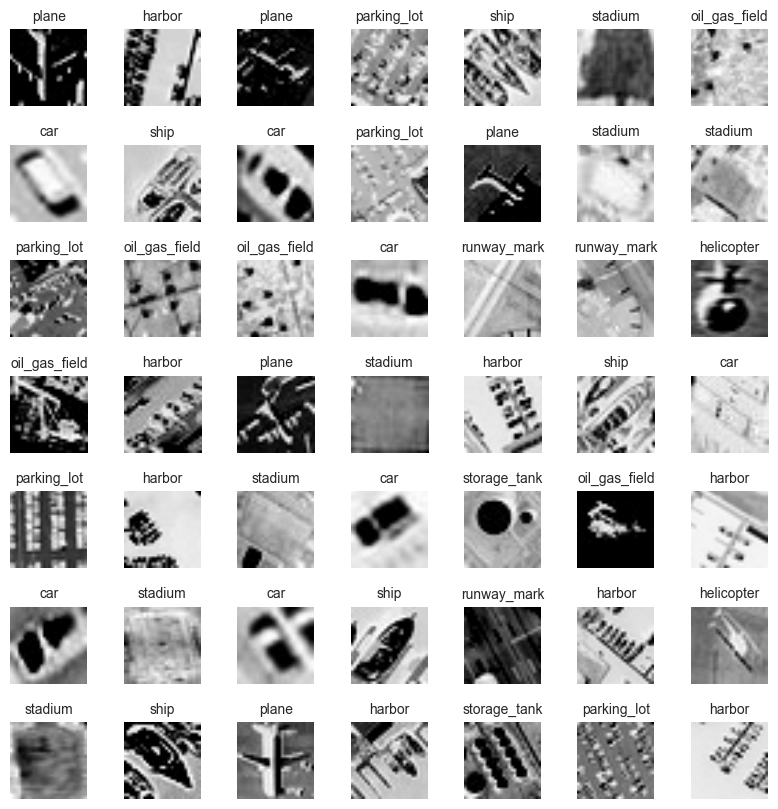

In [13]:
plotting(7, 7, train_X, train_y, labels)

### Reducing the dimentionality of our data using PCA

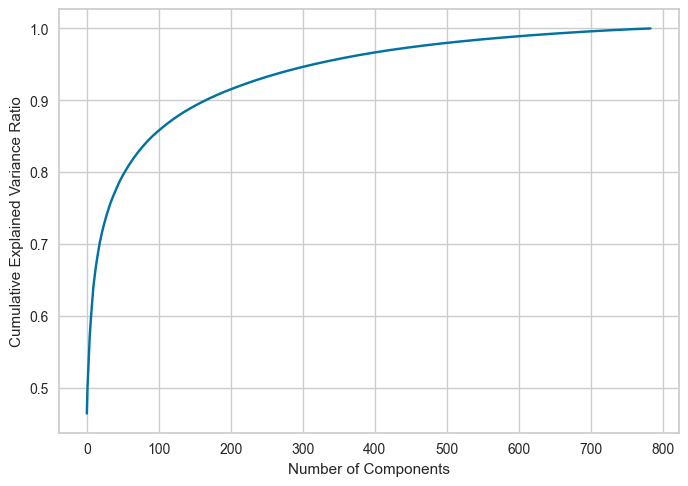

In [14]:
# choosing the n_components
pca = PCA(random_state=1)
pca.fit_transform(train_X)

# Plot the cumulative explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

- Since we see after n_components = 160, the cumulative sum starts to decrease, we choose it to be 160

In [15]:
pca = PCA(n_components = 160, random_state=1)
train_X_pca = pca.fit_transform(train_X)
print(f"The total variance captured by the principal components is {sum(pca.explained_variance_ratio_)*100:.2f}%")

The total variance captured by the principal components is 89.62%


In [16]:
# Reducing the dimension of the test dataset
test_X_pca = pca.transform(test_X)

### Calculating the best k for clustering (Elbow Method)

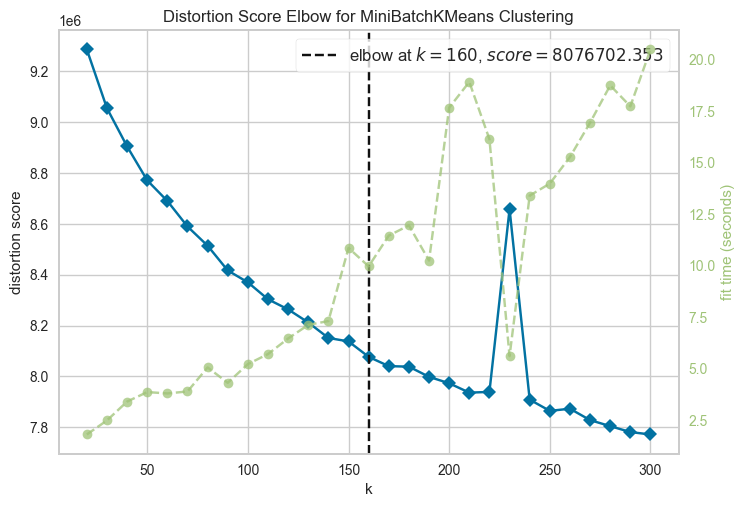

<Axes: title={'center': 'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
# Instantiate the clustering model and visualizer
kmeans = MiniBatchKMeans(init="k-means++", random_state=1, n_init="auto", batch_size = 200)
visualizer = KElbowVisualizer(kmeans, k = range(20, 301, 10))

visualizer.fit(train_X_pca)    # Fit the data to the visualizer
visualizer.poof()

In [19]:
best_k = 160
print("We have found the best k to be", best_k)

We have found the best k to be 160


### Training the best model

- Training a logistic regression model on the entire training dataset

In [20]:
lr = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter = 5000, random_state=1)
lr.fit(train_X_pca, train_y)
y_pred_test = lr.predict(test_X_pca)
print(f"Using logistic regression on the full data we get an accuracy of {accuracy_score(test_y, y_pred_test)*100:.2f}%")

Using logistic regression on the full data we get an accuracy of 41.75%


- Clustering the reduced datapoints in the training dataset to best_k clusters

In [21]:
kmeans = MiniBatchKMeans(init="k-means++", n_clusters=best_k, random_state=1, n_init="auto", batch_size=64)
X_dist = kmeans.fit_transform(train_X_pca)
representative_idx = np.argmin(X_dist, axis=0)                 # returns the index of the image closest to the centroid
X_representatives = train_X_pca[representative_idx]

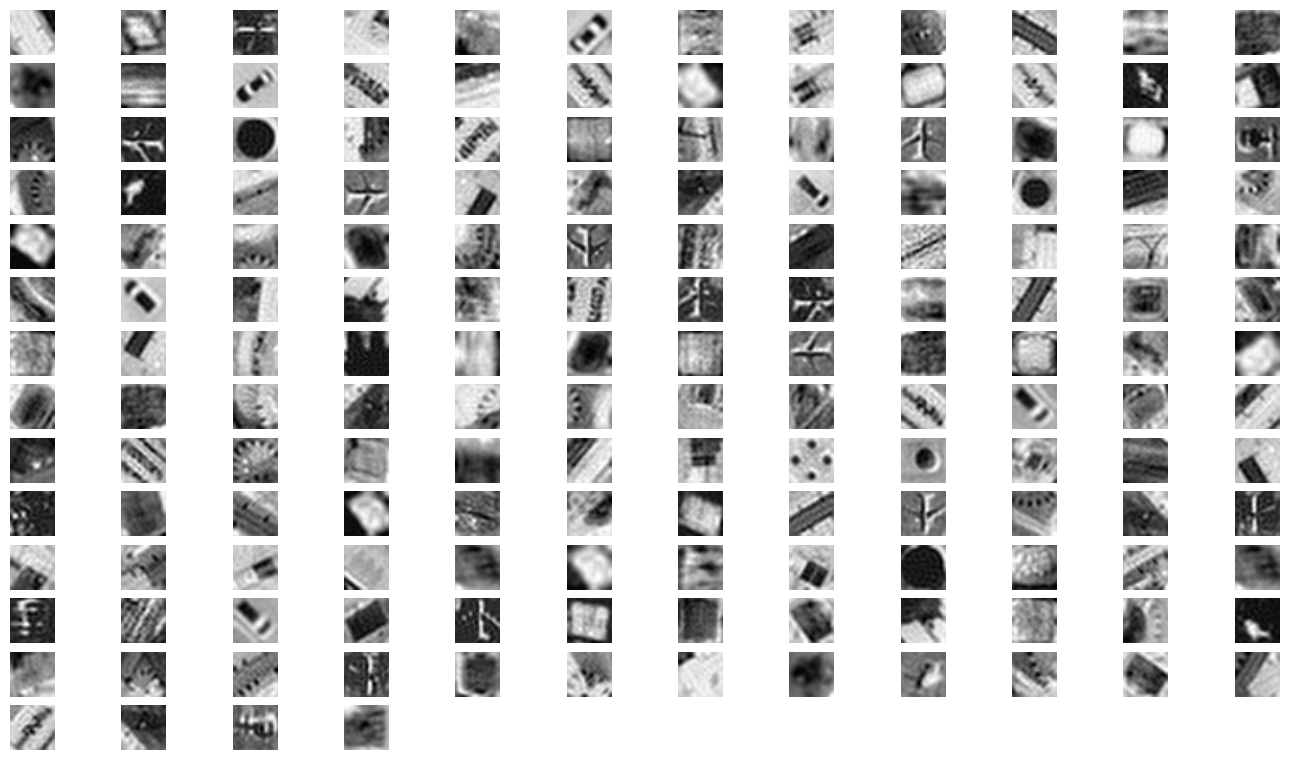

In [22]:
# plotting the representative images for each cluster
plt.figure(figsize=(17, 11))
for index, X_rep in enumerate(X_representatives):
    plt.subplot(best_k // 10, 12, index + 1)
    plt.imshow(pca.inverse_transform(X_rep).reshape(28, 28)*255, interpolation="bilinear", cmap="binary")
    plt.axis('off')
    
plt.show()

In [23]:
y_representatives = [8, 5, 7, 8, 5, 0, 5, 8, 6, 8, 5, 
                     5, 5, 5, 0, 2, 6, 2, 5, 8, 5, 2, 
                     3, 5, 8, 7, 1, 8, 2, 5, 8, 5, 7, 
                     5, 5, 4, 8, 4, 8, 7, 8, 5, 8, 0, 
                     5, 1, 6, 8, 5, 5, 8, 5, 8, 7, 6, 
                     6, 6, 8, 8, 5, 6, 0, 6, 5, 5, 2, 
                     7, 7, 5, 8, 5, 5, 5, 8, 8, 5, 5, 
                     5, 5, 7, 5, 5, 5, 5, 5, 5, 8, 8, 
                     8, 8, 1, 5, 2, 0, 5, 8, 6, 2, 8, 
                     5, 5, 8, 8, 1, 1, 5, 6, 8, 3, 5, 
                     8, 5, 6, 1, 5, 8, 7, 8, 8, 7, 8, 
                     8, 8, 5, 5, 5, 5, 8, 1, 1, 8, 5, 
                     4, 6, 0, 5, 7, 5, 5, 5, 5, 5, 8, 
                     4, 5, 8, 8, 7, 5, 8, 8, 5, 4, 8, 
                     5, 8, 2, 8, 4, 5]

### Training different classifiers with the cluster representatives

- Logistic Regression

In [24]:
%%time
%%memit
log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=5000, random_state=1)
log_reg.fit(X_representatives, y_representatives)
y_pred_test = log_reg.predict(test_X_pca)

peak memory: 1154.89 MiB, increment: 5.27 MiB
CPU times: user 427 ms, sys: 181 ms, total: 608 ms
Wall time: 785 ms


In [25]:
accuracy = accuracy_score(test_y, y_pred_test)
precision = precision_score(test_y, y_pred_test, average='weighted')
recall = recall_score(test_y, y_pred_test, average='weighted')
f1 = f1_score(test_y, y_pred_test, average='weighted')

print("Using the Logistic Regression Model we get: ")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Using the Logistic Regression Model we get: 
Accuracy: 0.183
Precision: 0.335
Recall: 0.183
F1-score: 0.171


- Multi Layer Perceptron

In [26]:
%%time
%%memit
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=1)
mlp.fit(X_representatives, y_representatives)
y_pred_test = mlp.predict(test_X_pca)

peak memory: 1205.41 MiB, increment: 49.95 MiB
CPU times: user 5.45 s, sys: 398 ms, total: 5.85 s
Wall time: 1.34 s


In [27]:
accuracy = accuracy_score(test_y, y_pred_test)
precision = precision_score(test_y, y_pred_test, average='weighted')
recall = recall_score(test_y, y_pred_test, average='weighted')
f1 = f1_score(test_y, y_pred_test, average='weighted')

print("Using the MLP Model we get: ")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Using the MLP Model we get: 
Accuracy: 0.157
Precision: 0.280
Recall: 0.157
F1-score: 0.126


- Support Vector Machine

In [28]:
%%time
%%memit
parameters = {'kernel' : ('linear', 'rbf'), 'C':[1, 10]}
svc = SVC()
svm = GridSearchCV(svc, parameters, n_jobs=-1)
svm.fit(X_representatives, y_representatives)
y_pred_test = svm.predict(test_X_pca)
print(svm.best_params_)

{'C': 10, 'kernel': 'rbf'}
peak memory: 199.91 MiB, increment: 48.81 MiB
CPU times: user 1.22 s, sys: 64 ms, total: 1.29 s
Wall time: 1.9 s


In [29]:
accuracy = accuracy_score(test_y, y_pred_test)
precision = precision_score(test_y, y_pred_test, average='weighted')
recall = recall_score(test_y, y_pred_test, average='weighted')
f1 = f1_score(test_y, y_pred_test, average='weighted')

print("Using the SVM Model we get: ")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Using the SVM Model we get: 
Accuracy: 0.242
Precision: 0.263
Recall: 0.242
F1-score: 0.199


### Propagating the labels to all the other instances in the same cluster

In [30]:
%%time
%%memit
y_train_propagated = np.empty(len(train_X_pca), dtype=np.int32)

for i in range(best_k):
    y_train_propagated[kmeans.labels_==i] = y_representatives[i]

param = {'kernel': ('rbf'), 'C': 10}
svc = SVC()
svm_full = GridSearchCV(svc, parameters, n_jobs=-1)
svm_full.fit(train_X_pca, y_train_propagated)
y_pred_test = svm_full.predict(test_X_pca)

accuracy = accuracy_score(test_y, y_pred_test)
print(accuracy)

0.2835215950704225
peak memory: 886.51 MiB, increment: 170.41 MiB
CPU times: user 2h 46min 47s, sys: 6min 50s, total: 2h 53min 37s
Wall time: 26min 51s


- We have increased the accuracy quite a bit. But in the same cluster images that are far away from the centroid, might not belong to the same class as the closest one. So let's only take the closest 20%

### Propagating the labels to the 20th percentile closest to the centroid

In [31]:
%%time
%%memit
percentile_closest = 20

X_cluster_dist = X_dist[np.arange(len(train_X_pca)), kmeans.labels_]

for i in range(best_k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = train_X_pca[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

param = {'kernel': ('rbf'), 'C': 10}
svc = SVC()
svm_partial = GridSearchCV(svc, parameters, n_jobs=-1)
svm_partial.fit(X_train_partially_propagated, y_train_partially_propagated)
y_pred_test = svm_partial.predict(test_X_pca)

accuracy = accuracy_score(test_y, y_pred_test)
print(accuracy)

0.2859507042253521
peak memory: 866.66 MiB, increment: 74.14 MiB
CPU times: user 2h 52min 39s, sys: 7min 20s, total: 2h 59min 59s
Wall time: 6min 15s


In [32]:
print(f"The accuracy of the propagated labels to the actual ones are around {np.mean(y_train_partially_propagated == train_y[partially_propagated])*100:.2f} %")

The accuracy of the propagated labels to the actual ones are around 47.59 %


### Plotting the confusion matrix for our Model

In [33]:
pred_y = svm_partial.predict(test_X_pca)
cm = classification_report(test_y, pred_y)

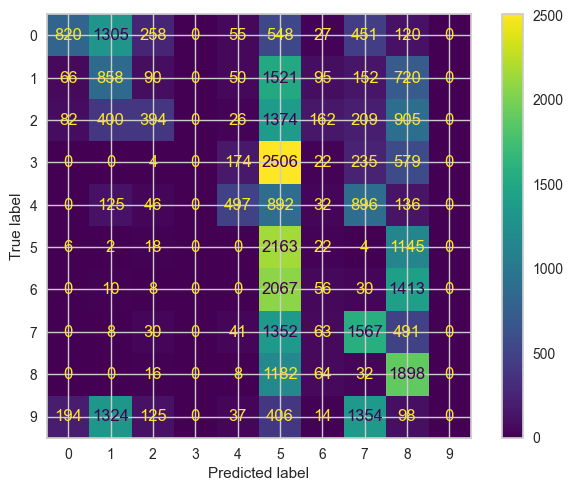

In [34]:
ConfusionMatrixDisplay.from_estimator(svm_partial, test_X_pca, test_y)
plt.show()

In [35]:
print("The Confusion Matrix: \n")
print(cm)

The Confusion Matrix: 

              precision    recall  f1-score   support

           0       0.79      0.07      0.14      3584
           1       0.64      0.13      0.22      3552
           2       0.50      0.00      0.00      3552
           3       0.24      0.25      0.24      3520
           4       0.83      0.66      0.61      2624
           5       0.11      0.81      0.19      3360
           6       0.09      0.07      0.08      3584
           7       0.81      0.32      0.33      3552
           8       0.09      0.04      0.05      3200
           9       0.79      0.42      0.44      3552

    accuracy                           0.29     34080
   macro avg       0.41      0.29      0.28     34080
weighted avg       0.42      0.28      0.28     34080

